In [229]:
# The code was removed by Watson Studio for sharing.

In [230]:
# The code was removed by Watson Studio for sharing.

In [231]:
# The code was removed by Watson Studio for sharing.

## Prepare Sensor Data for Machine Learning

#### Questions to consider?
* Is the data "clean"?
* Are there anomalies in the data?
* Should we use all the sensors?
* Is the 20Hz frequency a good frequency?
* What would be a good "time window" to aggregate the data given the movements we want to detect?
* What is an appropriate format to feed the algorithm?

### Install and Import required libraries (tools) to work with the data

In [232]:
## library to work with IBMs Object Storage
!pip install ibm-cos-sdk
## library to work with PostgreSQL Database
!pip install psycopg2-binary

In [233]:
import os
from datetime import datetime, timedelta
import psycopg2

import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime

import pytz
import time
from datetime import datetime
from dateutil import parser
import scipy.io as sio

import ibm_boto3
from botocore.client import Config

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Specify Database Connection

In [234]:
def connect_to_db(dbname,dbuser,dbpassword,dbhost,dbport,tablename):

    print( f"--- using {tablename} table ---")

    #print(dbname, user, password, host)
    try:
        conn = psycopg2.connect(dbname=dbname, user=dbuser, host=dbhost, port=dbport, password=dbpassword)
        cur = conn.cursor()
        print("connected to DB")
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("connection to db failed")

    return cur, conn, tablename

## Insert Database credentials

In [235]:
## click here and go to the right and "Connections" to insert database credentials

In [236]:
# The code was removed by Watson Studio for sharing.

In [237]:
dbname = credentials_1['database']
dbuser = credentials_1['username']
dbpassword = credentials_1['password']
dbhost = credentials_1['host']
dbport = credentials_1['port']
tablename = "youriboehler"

In [238]:
# The code was removed by Watson Studio for sharing.

In [239]:
cur, conn, tablename = connect_to_db(dbname,dbuser,dbpassword,dbhost,dbport,tablename)

--- using youriboehler table ---
connected to DB


### fetch the data and put it into a dataframe (table) and explore it a little

In [240]:
query = "SELECT * FROM " + tablename

In [241]:
df = pd.read_sql_query(query, conn)

/tmp/wsuser/ipykernel_167/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [242]:
df.head(20)

,id,username,sensortype,x,y,z,ts,class,device
0,1,youri,gyroscope,-0.246091,-0.111701,-0.132645,1699539975561,lying,android
1,2,youri,accelerometer,0.100000,5.000000,8.000000,1699539975562,lying,android
2,3,youri,gyroscope,-0.338594,-0.113446,-0.226893,1699539975611,lying,android
3,4,youri,accelerometer,0.300000,4.600000,8.300000,1699539975612,lying,android
4,5,youri,gyroscope,-0.293215,-0.090757,-0.230383,1699539975661,lying,android
5,6,youri,accelerometer,0.300000,4.700000,8.500000,1699539975675,lying,android
6,7,youri,gyroscope,-0.219911,-0.102974,-0.239110,1699539975711,lying,android
7,8,youri,accelerometer,0.400000,4.600000,8.900000,1699539975713,lying,android
8,9,youri,gyroscope,-0.089012,-0.165806,-0.232129,1699539975761,lying,android
9,10,youri,accelerometer,0.300000,4.500000,8.800000,1699539975762,lying,android


In [243]:
## How many Data Points are available?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18300 entries, 0 to 18299
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          18300 non-null  int64  
 1   username    18300 non-null  object 
 2   sensortype  18300 non-null  object 
 3   x           18300 non-null  float64
 4   y           18300 non-null  float64
 5   z           18300 non-null  float64
 6   ts          18300 non-null  int64  
 7   class       18300 non-null  object 
 8   device      18300 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 1.3+ MB


In [244]:
## Our current users that provided training data
set(df["username"])

{'youri'}

In [245]:
## the specifics of the values
df[df["sensortype"] == "accelerometer"].describe()

,id,x,y,z,ts
count,9110.000000,9110.000000,9110.000000,9110.000000,9.110000e+03
mean,9121.116905,0.171299,-0.424100,-3.792432,1.699540e+12
std,5294.654860,2.079630,2.270244,8.821352,1.997938e+05
min,2.000000,-13.288716,-8.713099,-20.002357,1.699540e+12
25%,4526.500000,-0.845415,-2.095637,-9.787235,1.699540e+12
50%,9104.000000,0.300000,-1.071031,-8.407613,1.699540e+12
75%,13703.500000,1.400000,1.500000,7.600000,1.699540e+12
max,18299.000000,9.300000,8.100000,21.600000,1.699541e+12


In [246]:
## the specifics of the values
df[df["sensortype"] == "gyroscope"].describe()

,id,x,y,z,ts
count,9190.000000,9190.000000,9190.000000,9190.000000,9.190000e+03
mean,9179.627312,99.942034,7.486832,-0.390187,1.699540e+12
std,5271.346626,115.210629,8.604255,8.769688,1.988581e+05
min,1.000000,-3.064798,-14.203054,-89.060710,1.699540e+12
25%,4626.500000,0.235619,0.146608,-1.829680,1.699540e+12
50%,9194.000000,42.804843,6.743501,0.099484,1.699540e+12
75%,13745.500000,191.789143,12.608091,2.698326,1.699540e+12
max,18300.000000,359.988800,170.855990,88.520485,1.699541e+12


### put in a human readable timestamp

In [247]:
df['timestamp'] = pd.to_datetime(df['ts'], unit='ms')

In [248]:
df['timestamp'].describe(datetime_is_numeric=True)

count                            18300
mean     2023-11-09 14:31:57.909662208
min         2023-11-09 14:26:15.561000
25%      2023-11-09 14:28:54.364499968
50%      2023-11-09 14:32:04.542000128
75%      2023-11-09 14:34:59.364499968
max         2023-11-09 14:37:20.285000
Name: timestamp, dtype: object

In [249]:
df.head(20)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
0,1,youri,gyroscope,-0.246091,-0.111701,-0.132645,1699539975561,lying,android,2023-11-09 14:26:15.561
1,2,youri,accelerometer,0.100000,5.000000,8.000000,1699539975562,lying,android,2023-11-09 14:26:15.562
2,3,youri,gyroscope,-0.338594,-0.113446,-0.226893,1699539975611,lying,android,2023-11-09 14:26:15.611
3,4,youri,accelerometer,0.300000,4.600000,8.300000,1699539975612,lying,android,2023-11-09 14:26:15.612
4,5,youri,gyroscope,-0.293215,-0.090757,-0.230383,1699539975661,lying,android,2023-11-09 14:26:15.661
5,6,youri,accelerometer,0.300000,4.700000,8.500000,1699539975675,lying,android,2023-11-09 14:26:15.675
6,7,youri,gyroscope,-0.219911,-0.102974,-0.239110,1699539975711,lying,android,2023-11-09 14:26:15.711
7,8,youri,accelerometer,0.400000,4.600000,8.900000,1699539975713,lying,android,2023-11-09 14:26:15.713
8,9,youri,gyroscope,-0.089012,-0.165806,-0.232129,1699539975761,lying,android,2023-11-09 14:26:15.761
9,10,youri,accelerometer,0.300000,4.500000,8.800000,1699539975762,lying,android,2023-11-09 14:26:15.762


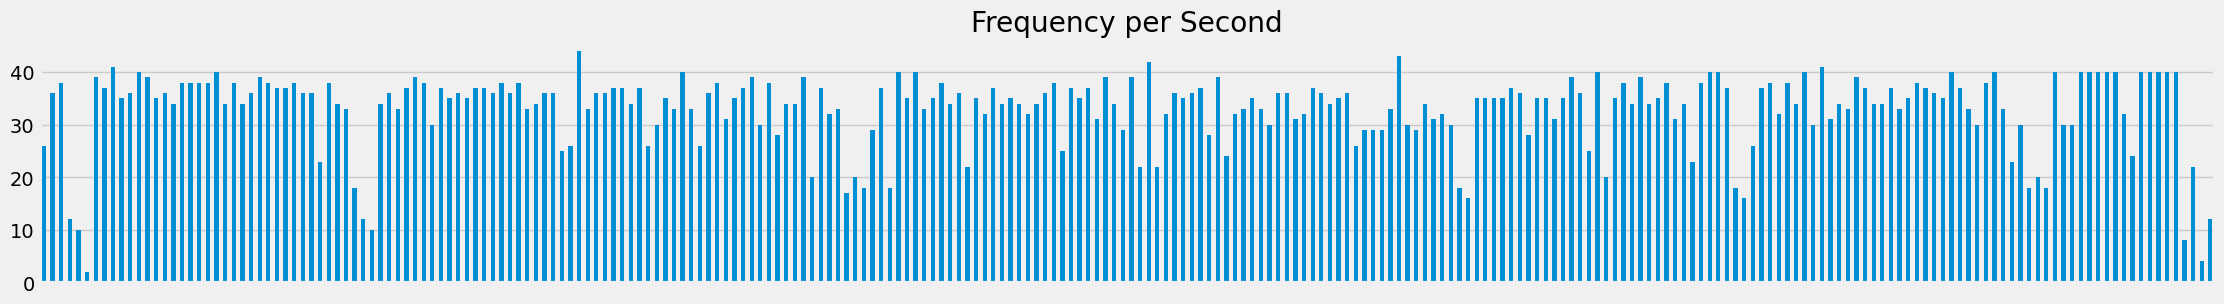

In [250]:
plt.figure(figsize=(25,3))
df["timestamp"][10000:20000].groupby([df["timestamp"].dt.day, df["timestamp"].dt.hour, df["timestamp"].dt.minute, df["timestamp"].dt.second]).count().plot(kind="bar", title="Frequency per Second")
ax1 = plt.gca()  # Get current axes
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)  # Hiding the x-axis

plt.show()

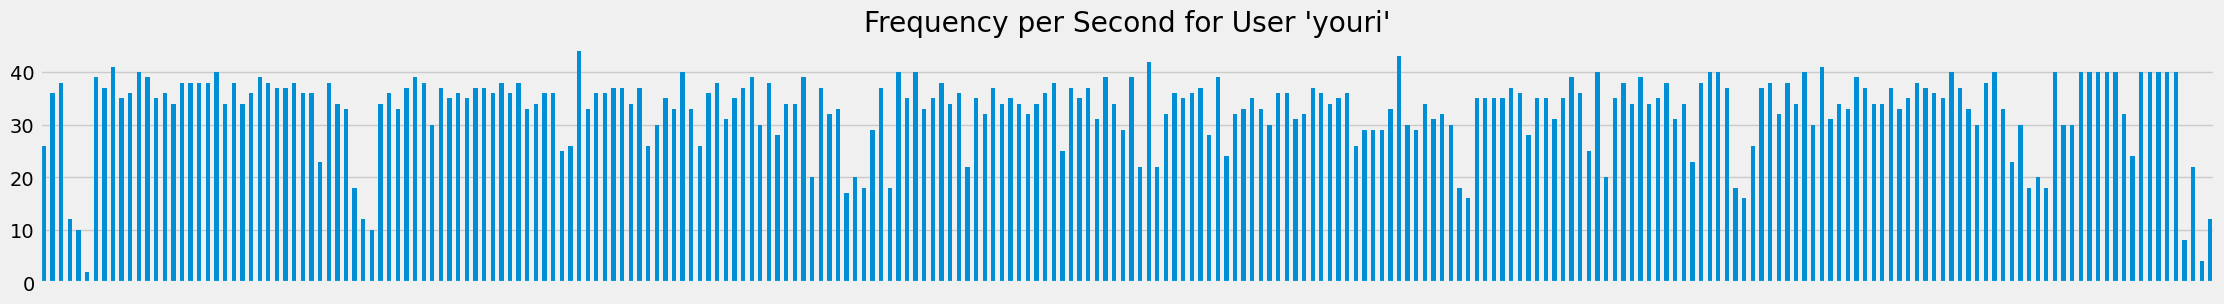

In [251]:
plt.figure(figsize=(25, 3))
df[(df["username"] == "youri")]["timestamp"][10000:20000].groupby([df["timestamp"].dt.day, df["timestamp"].dt.hour, df["timestamp"].dt.minute, df["timestamp"].dt.second]).count().plot(kind="bar", title="Frequency per Second for User 'youri'")
ax1 = plt.gca()  # Get current axes
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)  # Hiding the x-axis

plt.show()

In [252]:
### What is the frequency of our sensors?? Why does the first plot have those strong spikes? What about the minor ones in the second diagram?

### Which classes / labels are in our dataset

In [253]:
classes = list(set(df["class"]))
classes

['stairs', 'lying', 'walking']

In [254]:
for label in classes:
    items_per_class = len(df[df["class"]==label].index)
    print(f"datapoints for class {label}: {items_per_class}")

datapoints for class stairs: 6265
datapoints for class lying: 5120
datapoints for class walking: 6915


In [255]:
### Is this a good sample?

### Sort by User and Timestamps

In [256]:
df.tail(20)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
18280,18281,youri,accelerometer,0.036812,-2.706195,-9.635015,1699540638784,stairs,ios,2023-11-09 14:37:18.784
18281,18282,youri,gyroscope,214.096630,13.867727,-3.565184,1699540638785,stairs,ios,2023-11-09 14:37:18.785
18282,18283,youri,accelerometer,-0.676511,-2.675968,-8.524107,1699540638833,stairs,ios,2023-11-09 14:37:18.833
18283,18284,youri,gyroscope,214.129330,14.016610,-4.046364,1699540638834,stairs,ios,2023-11-09 14:37:18.834
18284,18285,youri,accelerometer,-2.181865,-2.567930,-9.960628,1699540639934,stairs,ios,2023-11-09 14:37:19.934
18285,18286,youri,gyroscope,211.598890,14.090961,-12.258118,1699540639934,stairs,ios,2023-11-09 14:37:19.934
18286,18287,youri,accelerometer,-2.839373,-1.754799,-8.970924,1699540639984,stairs,ios,2023-11-09 14:37:19.984
18287,18288,youri,gyroscope,212.998570,14.075376,-12.580827,1699540639985,stairs,ios,2023-11-09 14:37:19.985
18288,18289,youri,accelerometer,-2.285115,-2.265961,-8.754698,1699540640034,stairs,ios,2023-11-09 14:37:20.034
18289,18290,youri,gyroscope,213.607730,14.220176,-12.363584,1699540640034,stairs,ios,2023-11-09 14:37:20.034


In [257]:
df_sorted = df.sort_values(['username', 'ts'], ascending=[True, True])

In [258]:
df_sorted[df_sorted["username"] == "youri"].tail(10)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
18290,18291,youri,accelerometer,-2.308758,-2.356941,-8.605808,1699540640084,stairs,ios,2023-11-09 14:37:20.084
18291,18292,youri,gyroscope,213.991550,14.269723,-12.078507,1699540640084,stairs,ios,2023-11-09 14:37:20.084
18292,18293,youri,accelerometer,-2.106298,-2.083254,-9.304766,1699540640134,stairs,ios,2023-11-09 14:37:20.134
18293,18294,youri,gyroscope,214.422670,14.008594,-11.437890,1699540640135,stairs,ios,2023-11-09 14:37:20.135
18294,18295,youri,accelerometer,-2.095375,-2.022800,-9.561694,1699540640184,stairs,ios,2023-11-09 14:37:20.184
18295,18296,youri,gyroscope,214.813020,13.781256,-10.777845,1699540640184,stairs,ios,2023-11-09 14:37:20.184
18296,18297,youri,accelerometer,-1.873163,-2.268356,-9.473257,1699540640234,stairs,ios,2023-11-09 14:37:20.234
18297,18298,youri,gyroscope,214.931020,13.785252,-10.029266,1699540640235,stairs,ios,2023-11-09 14:37:20.235
18298,18299,youri,accelerometer,-1.589450,-2.332550,-9.368361,1699540640284,stairs,ios,2023-11-09 14:37:20.284
18299,18300,youri,gyroscope,215.173160,13.757150,-9.340583,1699540640285,stairs,ios,2023-11-09 14:37:20.285


In [259]:
### What could be good reasons for sorting the table by username first and then by timestamp?

### Investigate our two sensor more thorougly?

#### Give numbers to classes for coloring in 3D scatter

In [260]:
df_sorted['class_num'] = pd.factorize(df_sorted['class'])[0]
colors = np.array(["green", "black", "red"])

In [261]:
df_sorted["class"].unique()

array(['lying', 'walking', 'stairs'], dtype=object)

In [262]:
df_sorted["class_num"].unique()

array([0, 1, 2])

In [263]:
gyro_colors_ios = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "ios"]["class_num"]
gyro_colors_android = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "android"]["class_num"]


/tmp/wsuser/ipykernel_167/2686996040.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gyro_colors_ios = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "ios"]["class_num"]
/tmp/wsuser/ipykernel_167/2686996040.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gyro_colors_android = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "android"]["class_num"]


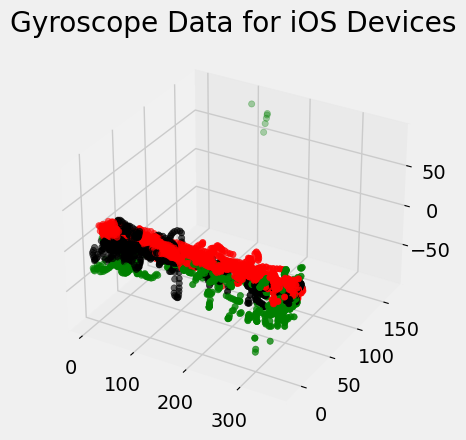

In [264]:
# Filtering the data
gyro_ios_mask = (df["sensortype"] == "gyroscope") & (df["device"] == "ios")
zdata = df[gyro_ios_mask]["z"]
xdata = df[gyro_ios_mask]["x"]
ydata = df[gyro_ios_mask]["y"]


# Plotting the data
from mpl_toolkits.mplot3d import Axes3D  # This is necessary for 3D plotting

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xdata, ydata, zdata, c=colors[gyro_colors_ios])
ax.set_title("Gyroscope Data for iOS Devices")

plt.show()

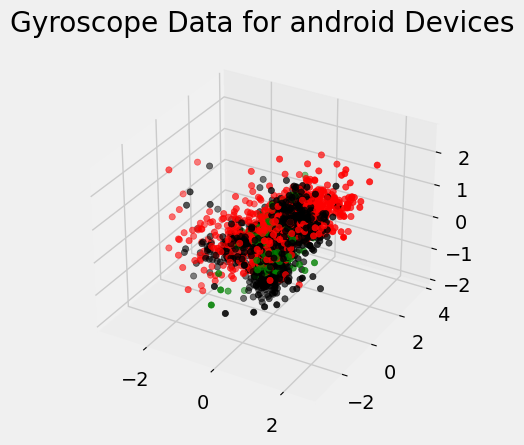

In [265]:
# Filtering the data
gyro_android_mask = (df["sensortype"] == "gyroscope") & (df["device"] == "android")
zdata = df[gyro_android_mask]["z"]
xdata = df[gyro_android_mask]["x"]
ydata = df[gyro_android_mask]["y"]


# Plotting the data
from mpl_toolkits.mplot3d import Axes3D  # This is necessary for 3D plotting

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xdata, ydata, zdata, c=colors[gyro_colors_android])
ax.set_title("Gyroscope Data for android Devices")

plt.show()

In [266]:
df_sorted = df_sorted[df_sorted["sensortype"]=="accelerometer"]

### Akzelerometer untersuchen

In [267]:
df_sorted.head(21)
### We can see that there are 20 values per second from the accelerometer

,id,username,sensortype,x,y,z,ts,class,device,timestamp,class_num
1,2,youri,accelerometer,0.100000,5.000000,8.000000,1699539975562,lying,android,2023-11-09 14:26:15.562,0
3,4,youri,accelerometer,0.300000,4.600000,8.300000,1699539975612,lying,android,2023-11-09 14:26:15.612,0
5,6,youri,accelerometer,0.300000,4.700000,8.500000,1699539975675,lying,android,2023-11-09 14:26:15.675,0
7,8,youri,accelerometer,0.400000,4.600000,8.900000,1699539975713,lying,android,2023-11-09 14:26:15.713,0
9,10,youri,accelerometer,0.300000,4.500000,8.800000,1699539975762,lying,android,2023-11-09 14:26:15.762,0
11,12,youri,accelerometer,0.100000,4.400000,9.000000,1699539975844,lying,android,2023-11-09 14:26:15.844,0
13,14,youri,accelerometer,-0.100000,4.400000,8.900000,1699539975863,lying,android,2023-11-09 14:26:15.863,0
16,17,youri,accelerometer,0.400000,4.500000,8.600000,1699539976413,lying,android,2023-11-09 14:26:16.413,0
18,19,youri,accelerometer,0.400000,4.400000,8.600000,1699539976485,lying,android,2023-11-09 14:26:16.485,0
20,21,youri,accelerometer,0.200000,4.200000,8.400000,1699539976516,lying,android,2023-11-09 14:26:16.516,0


In [268]:
df_sorted.describe()

,id,x,y,z,ts,class_num
count,9110.000000,9110.000000,9110.000000,9110.000000,9.110000e+03,9110.000000
mean,9121.116905,0.171299,-0.424100,-3.792432,1.699540e+12,1.059166
std,5294.654860,2.079630,2.270244,8.821352,1.997938e+05,0.788204
min,2.000000,-13.288716,-8.713099,-20.002357,1.699540e+12,0.000000
25%,4526.500000,-0.845415,-2.095637,-9.787235,1.699540e+12,0.000000
50%,9104.000000,0.300000,-1.071031,-8.407613,1.699540e+12,1.000000
75%,13703.500000,1.400000,1.500000,7.600000,1.699540e+12,2.000000
max,18299.000000,9.300000,8.100000,21.600000,1.699541e+12,2.000000


In [269]:
accel_colors = df_sorted["class_num"]

Text(0.5, 0.92, 'Accelerometer Data for both Device Types')

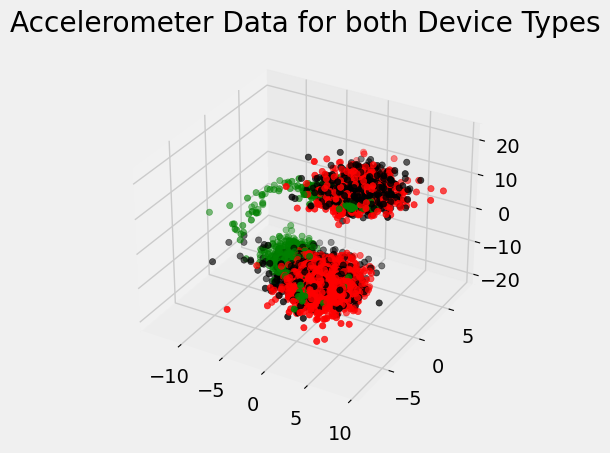

In [270]:
# Data for three-dimensional scattered points
zdata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["z"]
xdata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["x"]
ydata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[accel_colors])
plt.title("Accelerometer Data for both Device Types")

Text(0.5, 1.0, "Accelerometer Data for 'lying' ")

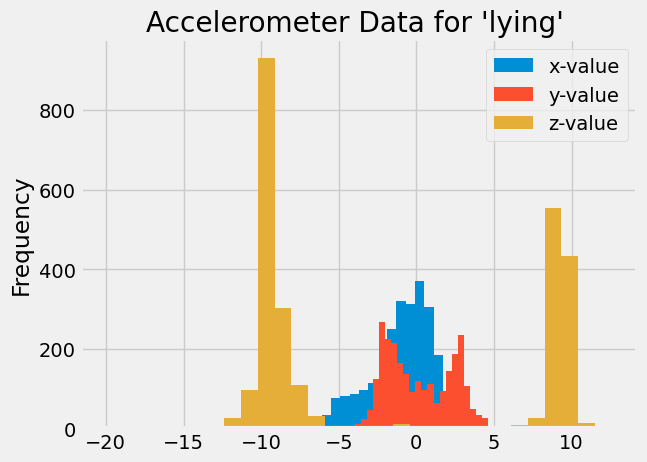

In [271]:
df_sorted[df_sorted["class"] == "lying"]["x"].plot.hist(bins=30, label="x-value")
df_sorted[df_sorted["class"] == "lying"]["y"].plot.hist(bins=30, label="y-value")
df_sorted[df_sorted["class"] == "lying"]["z"].plot.hist(bins=30, label="z-value")
plt.legend()
plt.title("Accelerometer Data for 'lying' ")

Text(0.5, 1.0, "Accelerometer Data for 'walking' ")

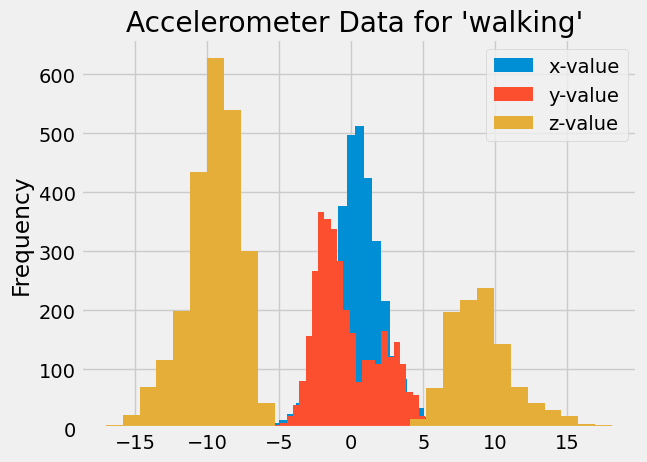

In [272]:
df_sorted[df_sorted["class"] == "walking"]["x"].plot.hist(bins=30, label="x-value")
df_sorted[df_sorted["class"] == "walking"]["y"].plot.hist(bins=30, label="y-value")
df_sorted[df_sorted["class"] == "walking"]["z"].plot.hist(bins=30, label="z-value")
plt.legend()
plt.title("Accelerometer Data for 'walking' ")

Text(0.5, 1.0, "Accelerometer Data for 'stairs' ")

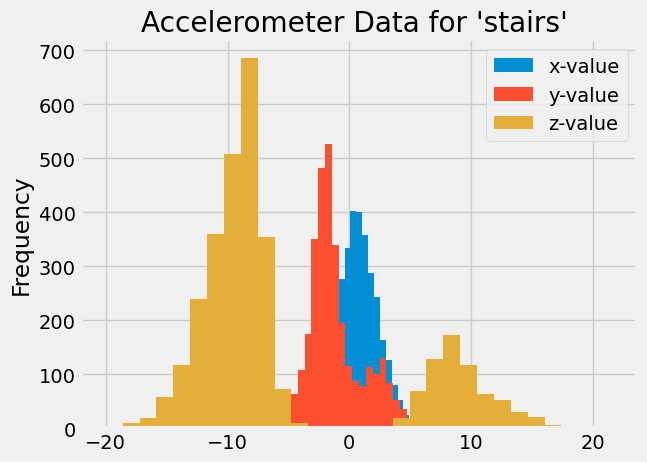

In [273]:
df_sorted[df_sorted["class"] == "stairs"]["x"].plot.hist(bins=30, label="x-value")
df_sorted[df_sorted["class"] == "stairs"]["y"].plot.hist(bins=30, label="y-value")
df_sorted[df_sorted["class"] == "stairs"]["z"].plot.hist(bins=30, label="z-value")
plt.legend()
plt.title("Accelerometer Data for 'stairs' ")

In [274]:
classes = list(set(df_sorted["class"]))
classes

['stairs', 'lying', 'walking']

In [275]:
len(df_sorted.index)

9110

### Put the data into a format feaseable for Machine Learning and Aggregate the data to a certain time window

In [276]:
entries_to_agg = 10
df_new = pd.DataFrame()
my_list = []
my_list_labels = []
my_timestamps = []
for i in range(0,len(df_sorted.index),entries_to_agg):
        my_list.append(df_sorted.iloc[i:i+entries_to_agg,[3,4,5]].values)
        my_list_labels.append(df_sorted.iloc[i:i+entries_to_agg,7].values)
        my_timestamps.append((df_sorted.iloc[i:i+entries_to_agg,9].values))
        if i == 0:
            print(my_list_labels)

[array(['lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying'], dtype=object)]


In [277]:
df_new["time_window"] = my_timestamps
df_new["values"] = my_list
df_new["classes_in_time_window"] = my_list_labels

In [278]:
len(df_new)

911

In [279]:
df_new.head()

,time_window,values,classes_in_time_window
0,"[2023-11-09T14:26:15.562000000, 2023-11-09T14:...","[[0.1, 5.0, 8.0], [0.3, 4.6, 8.3], [0.3, 4.7, ...","[lying, lying, lying, lying, lying, lying, lyi..."
1,"[2023-11-09T14:26:16.562000000, 2023-11-09T14:...","[[0.0, 4.3, 8.7], [0.5, 4.4, 9.5], [0.4, 4.3, ...","[lying, lying, lying, lying, lying, lying, lyi..."
2,"[2023-11-09T14:26:17.212000000, 2023-11-09T14:...","[[1.2, 3.0, 10.0], [-0.865953, -2.2417212, -9....","[lying, lying, lying, lying, lying, lying, lyi..."
3,"[2023-11-09T14:26:17.945000000, 2023-11-09T14:...","[[-1.3344681, -2.1615152, -9.974394], [1.2, 2....","[lying, lying, lying, lying, lying, lying, lyi..."
4,"[2023-11-09T14:26:18.445000000, 2023-11-09T14:...","[[-0.6076785, -2.146103, -9.683199], [-0.23298...","[lying, lying, lying, lying, lying, lying, lyi..."


In [280]:
df_new["time_window"][0]

array(['2023-11-09T14:26:15.562000000', '2023-11-09T14:26:15.612000000',
       '2023-11-09T14:26:15.675000000', '2023-11-09T14:26:15.713000000',
       '2023-11-09T14:26:15.762000000', '2023-11-09T14:26:15.844000000',
       '2023-11-09T14:26:15.863000000', '2023-11-09T14:26:16.413000000',
       '2023-11-09T14:26:16.485000000', '2023-11-09T14:26:16.516000000'],
      dtype='datetime64[ns]')

In [281]:
data_flat = []
class_in_time_window = []
timewindow_start = []
for i in range(0,len(df_new)-5,1):
    values = np.concatenate((df_new["values"][i]), axis=None)
    classes = np.concatenate((df_new["classes_in_time_window"][i]), axis=None)
    timewindow = np.concatenate((df_new["time_window"][i]), axis=None)
    data_flat.append(values)
    class_in_time_window.append(classes[0])
    timewindow_start.append(timewindow[0])

In [282]:
print(timewindow_start[0])

2023-11-09T14:26:15.562000000


In [283]:
timewindow_start[1]
timewindow_start[2]
timewindow_start[2] - timewindow_start[1]
## eine halbe Sekunde?

numpy.timedelta64(650000000,'ns')

In [284]:
len(data_flat[0])

30

In [285]:
class_in_time_window[0]

'lying'

### Putting everything into a function

In [286]:
def aggregate_data(df, entries_to_agg=10):
    df_new = pd.DataFrame()
    my_list = []
    my_list_labels = []
    my_timestamps = []
    for i in range(0,len(df.index),entries_to_agg):
            my_list.append(df.iloc[i:i+entries_to_agg,[3,4,5]].values)
            my_list_labels.append(df.iloc[i:i+entries_to_agg,7].values)
            my_timestamps.append((df.iloc[i:i+entries_to_agg,9].values))
    df_new["time_window"] = my_timestamps
    df_new["values"] = my_list
    df_new["classes_in_time_window"] = my_list_labels

    data_flat = []
    class_in_time_window = []
    timewindow_start = []
    for i in range(0,len(df_new)-5,1):
        values = np.concatenate((df_new["values"][i]), axis=None)
        classes = np.concatenate((df_new["classes_in_time_window"][i]), axis=None)
        timewindow = np.concatenate((df_new["time_window"][i]), axis=None)
        data_flat.append(values)
        class_in_time_window.append(classes[0])
        timewindow_start.append(timewindow[0])
    return data_flat, class_in_time_window, timewindow_start

In [287]:
train_X_agg, train_y_agg, time_window = aggregate_data(df_sorted)

In [288]:
set(train_y_agg)

{'lying', 'stairs', 'walking'}

In [289]:
len(train_X_agg[0])

30

In [290]:
time_window[500]

numpy.datetime64('2023-11-09T14:32:26.487000000')

In [291]:
df_prepared = pd.DataFrame(list(zip(train_X_agg, train_y_agg, time_window)), columns=["values", "labels", "time_window_start"])

In [292]:
df_prepared.head(10)

,values,labels,time_window_start
0,"[0.1, 5.0, 8.0, 0.3, 4.6, 8.3, 0.3, 4.7, 8.5, ...",lying,2023-11-09 14:26:15.562
1,"[0.0, 4.3, 8.7, 0.5, 4.4, 9.5, 0.4, 4.3, 8.5, ...",lying,2023-11-09 14:26:16.562
2,"[1.2, 3.0, 10.0, -0.865953, -2.2417212, -9.334...",lying,2023-11-09 14:26:17.212
3,"[-1.3344681, -2.1615152, -9.974394, 1.2, 2.3, ...",lying,2023-11-09 14:26:17.945
4,"[-0.6076785, -2.146103, -9.683199, -0.2329859,...",lying,2023-11-09 14:26:18.445
5,"[-0.9510968, -2.617611, -8.953715, 0.5, 3.4, 8...",lying,2023-11-09 14:26:18.995
6,"[-0.3, 2.7, 9.2, -0.4, 2.8, 8.5, -2.5849895, -...",lying,2023-11-09 14:26:19.563
7,"[-3.6990416, -1.1077675, -9.771186, -3.6973956...",lying,2023-11-09 14:26:20.195
8,"[-3.7270238, -1.2563577, -9.293393, 1.4, 2.8, ...",lying,2023-11-09 14:26:20.695
9,"[0.1, 2.8, 10.6, -0.6, 2.1, 9.3, -0.7, 1.8, 8....",lying,2023-11-09 14:26:21.162


In [293]:
len(df_prepared["values"][0])

30

### Save prepared data preserving format

In [294]:
#filename = "sensor_data_prepared.pkl"
#df_prepared.to_pickle(filename)

In [295]:
#!ls

## create Project-ID & Project Token

In [296]:
# project_id = "4b787fdc-f324-4243-ac37-862ad88578d6"
# project_token = "p-38ed25004e585910813c8e45e08804ee19ecb155"

In [297]:
#import io
#from project_lib import Project
#sc= None

#project = Project(sc,project_id,project_token)

#with open(filename, 'rb') as z:
        #data = io.BytesIO(z.read())
        #project.save_data(
         #   filename, data, set_project_asset=True, overwrite=True
        #)

### save modified version for OpenScale and AutoAI as csv

In [298]:
column_names = []
sensor_labels = ["x", "y", "z"]    ### change to this when gyroscope is included: ["x", "y", "z", "alpha", "gamma", "beta"]
iterations = int(len(df_prepared["values"].tolist()[0])/int(len(sensor_labels)))
for i in range(0,iterations, 1):
    sensor_labels_temp = [ current_label + "_" + str(i+1) for current_label in sensor_labels]
    column_names.append(sensor_labels_temp)
column_names = np.concatenate(column_names, axis=None)

In [299]:
df_prepared_autoai = pd.DataFrame(df_prepared["values"].tolist(), columns=column_names)

In [300]:
df_prepared_autoai["classes"] = df_prepared["labels"]
## df_prepared_autoai["time_window"] = df_prepared["time_window_start"]

In [301]:
df_prepared_autoai.head()

,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,...,x_8,y_8,z_8,x_9,y_9,z_9,x_10,y_10,z_10,classes
0,0.100000,5.000000,8.000000,0.300000,4.600000,8.300000,0.300000,4.700000,8.500000,0.400000,...,0.400000,4.500000,8.600000,0.400000,4.400000,8.600000,0.200000,4.200000,8.400000,lying
1,0.000000,4.300000,8.700000,0.500000,4.400000,9.500000,0.400000,4.300000,8.500000,0.500000,...,-1.045368,-2.883517,-10.029460,1.000000,3.200000,9.000000,1.300000,2.900000,9.600000,lying
2,1.200000,3.000000,10.000000,-0.865953,-2.241721,-9.334393,-0.960973,-2.677615,-9.358933,-1.146972,...,1.600000,2.800000,9.400000,-1.408688,-2.398242,-9.809941,-1.455076,-1.701978,-8.887726,lying
3,-1.334468,-2.161515,-9.974394,1.200000,2.300000,8.800000,-1.262642,-1.631649,-9.716418,0.900000,...,-1.270124,-1.796100,-9.880870,-1.032949,-1.584513,-9.470264,-0.702998,-2.222867,-9.504532,lying
4,-0.607679,-2.146103,-9.683199,-0.232986,-2.323872,-9.617807,0.800000,3.300000,9.500000,0.600000,...,-0.097714,-2.529774,-9.417143,-0.042647,-2.827702,-9.632172,-0.377685,-2.670583,-9.926210,lying


In [302]:
project.save_data(file_name = "sensor_data_prepared_autoai.csv",data = df_prepared_autoai.to_csv(index=False), set_project_asset=True, overwrite=True)

{'file_name': 'sensor_data_prepared_autoai.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'sensorappyouriboehler-donotdelete-pr-emrygwzyt9mhli',
 'asset_id': 'e855ca6b-effb-48aa-9f39-f8e1a1b69412'}